# AR Sliding Window

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, HTML
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey
from statsmodels.api import OLS, add_constant
from scipy.stats import shapiro, anderson
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from scipy import stats
from statsmodels.stats.stattools import durbin_watson
import pmdarima as pm
from itertools import product
from itertools import product
import re
from tqdm import tqdm
from IPython.display import display, Markdown
from joblib import Parallel, delayed

In [15]:
# Load data
df = pd.read_excel('data/Monthly Mastersheet with Original Data.xlsx')
# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()

In [16]:
df_exog = pd.read_excel('data/All Exogenous Variables.xlsx')
# Ensure date is datetime and set index
df_exog['Month'] = pd.to_datetime(df_exog['Month'])
df_exog.set_index('Month', inplace=True)
df_exog.index = pd.date_range(start=df_exog.index[0], periods=len(df_exog), freq='MS')
df_exog.columns = df_exog.columns.str.strip()

In [17]:
warnings.filterwarnings(
    "ignore",
    message=re.escape("'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8."),
    category=FutureWarning,
    module=r"sklearn\.utils\.deprecation"
)

In [18]:
macro_list = ['LFPR', 'CPI', 'r', 'M1', 'GDP', 'IM', 'EX', 'CC']

In [19]:
windows = [
    ('2019-07-01', '2022-02-01'),
    ('2022-04-01', '2025-01-01')
]

In [20]:
def check_model_assumptions(y_train, X_train, model_residuals):
    model_residuals = model_residuals[4:]
    assumptions = {}

    if X_train.shape[1] > 0:
        # Add constant
        X_const = add_constant(X_train)

        # Only run BP if enough columns
        if X_const.shape[1] >= 2:
            ols_model = OLS(y_train, X_const).fit()
            bp_stat, bp_pvalue, _, _ = het_breuschpagan(ols_model.resid, X_const)
            assumptions["Breusch-Pagan p"] = bp_pvalue
        else:
            assumptions["Breusch-Pagan p"] = np.nan
    else:
        assumptions["Breusch-Pagan p"] = np.nan

    # Normality
    shapiro_stat, shapiro_p = shapiro(model_residuals)
    ad_result = anderson(model_residuals)
    assumptions["Shapiro p"] = shapiro_p
    assumptions["Anderson stat"] = ad_result.statistic
    assumptions["Anderson crit"] = list(zip(ad_result.significance_level, ad_result.critical_values))

    # Residual mean
    assumptions["Mean resid"] = model_residuals.mean()

    # Autocorrelation
    assumptions["Durbin-Watson"] = durbin_watson(model_residuals)

    return assumptions


In [21]:
def calc_metrics(y_true_train, y_pred_train, y_true_test, y_pred_test):
    # Training R^2
    # Exclude first 4 values from train R² calculation
    y_true_train_trimmed = y_true_train[4:]
    y_pred_train_trimmed = y_pred_train[4:]
    r2 = r2_score(y_true_train_trimmed, y_pred_train_trimmed)

    # Test errors
    mae = mean_absolute_error(y_true_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
    # Handle possible zeros in true values for MAPE
    y_true_test_nonzero = y_true_test.replace(0, np.nan).dropna()
    y_pred_test_aligned = y_pred_test[y_true_test_nonzero.index]
    mape = np.mean(np.abs((y_true_test_nonzero - y_pred_test_aligned) / y_true_test_nonzero)) * 100

    return {'R2_train': r2, 'MAE_test': mae, 'RMSE_test': rmse, 'MAPE_test': mape}

In [ ]:
def run_model(macro, exog, window, show = False):
    start_date, end_date = pd.to_datetime(window[0]), pd.to_datetime(window[1])

    # Select y series and exog window
    y = df[macro].loc[start_date:end_date].dropna().asfreq('MS')
    exog = df_exog[exog].dropna().asfreq('MS')
    exog_window = exog.loc[start_date:end_date].dropna().asfreq('MS')

    # Align
    y, exog_window = y.align(exog_window, join='inner')

    # Train-test split
    split_idx = int(len(y) * 0.8)
    train, test = y[:split_idx], y[split_idx:]
    exog_train, exog_test = exog_window[:split_idx], exog_window[split_idx:]

    # AR model
    model_ar = pm.auto_arima(
        train,
        start_p=1, start_q=0, start_P=0, start_Q=0,
        max_p=5, max_q=5, max_P=2, max_Q=2, D=1,
        m=3,
        seasonal=True,
        stepwise=True,
        suppress_warnings=True
    )
    forecast_ar, conf_int_ar = model_ar.predict(n_periods=len(test), return_conf_int=True)
    fitted_ar = pd.Series(model_ar.predict_in_sample(), index=train.index)

    # ARX model
    model_arx = pm.auto_arima(
        train,
        X=exog_train,
        seasonal=True,
        m=3,
        start_p=1, start_q=0, D = 1,
        max_p=3, max_q=5,
        max_P=2, max_Q=2,
        stepwise=True,
        trace=False,
        suppress_warnings=True
    )
    forecast_arx, conf_int_arx = model_arx.predict( n_periods=len(test), X=exog_test, return_conf_int=True)
    fitted_arx = pd.Series(model_arx.predict_in_sample(X=exog_train), index=train.index)

    # Print orders
    print("AR Order:", model_ar.order, "Seasonal:", model_ar.seasonal_order)
    print("ARX Order:", model_arx.order, "Seasonal:", model_arx.seasonal_order)

    print("\n=== AR Model Summary ===")
    print(model_ar.arima_res_.summary())
    print("\n=== ARX Model Summary ===")
    print(model_arx.arima_res_.summary())

    # Calculate metrics
    metrics_ar = calc_metrics(train, fitted_ar, test, forecast_ar)
    metrics_arx = calc_metrics(train, fitted_arx, test, forecast_arx)

    if show:
        # Plot 1: Full window with both forecasts
        plt.figure(figsize=(10, 5))
        plt.plot(y.index, y, label='Actual', color='black')
        plt.plot(test.index, forecast_ar, label='AR Forecast', linestyle='--', color='blue')
        plt.plot(test.index, forecast_arx, label='ARX Forecast', linestyle='--', color='red')
        plt.fill_between(test.index, conf_int_ar[:, 0], conf_int_ar[:, 1], color='lightblue', alpha=0.2, label='AR CI')
        plt.fill_between(test.index, conf_int_arx[:, 0], conf_int_arx[:, 1], color='pink', alpha=0.2, label='ARX CI')
        plt.axvline(x=test.index[0], color='gray', linestyle=':', label='Train/Test Split')
        plt.title(f'Full Window Forecast: {macro}')
        plt.xlabel('Date')
        plt.ylabel(macro)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Plot 2: Zoomed in on test period
        plt.figure(figsize=(10, 5))
        plt.plot(test.index, test, label='Actual', marker='o', color='black')
        plt.plot(test.index, forecast_ar, label='AR Forecast', linestyle='--', marker='x', color='blue')
        plt.plot(test.index, forecast_arx, label='ARX Forecast', linestyle='--', marker='^', color='red')
        plt.fill_between(test.index, conf_int_ar[:, 0], conf_int_ar[:, 1], color='lightblue', alpha=0.2, label='AR CI')
        plt.fill_between(test.index, conf_int_arx[:, 0], conf_int_arx[:, 1], color='pink', alpha=0.2, label='ARX CI')
        plt.title(f'Test Period: {macro} Forecast Comparison')
        plt.xlabel('Date')
        plt.ylabel(macro)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Check model assumption
    # Get residuals (actual - fitted)
    resid_ar = train - fitted_ar
    resid_arx = train - fitted_arx

    # Run assumption checks
    assumptions_ar = check_model_assumptions(train, pd.DataFrame(index=train.index), resid_ar)
    assumptions_arx = check_model_assumptions(train, exog_train, resid_arx)

    # Combine and display metrics
    metrics_df = pd.DataFrame([metrics_ar, metrics_arx], index=['AR', 'ARX'])
    assumptions_df = pd.DataFrame([assumptions_ar, assumptions_arx], index=['AR', 'ARX'])
    if show:
        display(Markdown("### Model Forecast Accuracy Metrics"))
        display(metrics_df.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))
        display(Markdown("### Model Assumption Check"))
        display(assumptions_df.style.set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}]))

    # Extract exogenous p-values from ARX model
    exog_pvals = model_arx.arima_res_.pvalues
    exog_pvals = exog_pvals[exog_train.columns.intersection(exog_pvals.index)]

    return {
        'metrics_ar': metrics_ar,
        'metrics_arx': metrics_arx,
        'model_ar_order': model_ar.order,
        'model_ar_seasonal_order': model_ar.seasonal_order,
        'model_arx_order': model_arx.order,
        'model_arx_seasonal_order': model_arx.seasonal_order,
        'assumptions_ar': assumptions_ar,
        'assumptions_arx': assumptions_arx,
        'exog_pvals': exog_pvals.to_dict(),
        'y_test': test,
        'y_pred': pd.Series(forecast_arx, index=test.index)
    }

AR Order: (0, 0, 1) Seasonal: (1, 1, 0, 3)
ARX Order: (2, 0, 0) Seasonal: (2, 1, 1, 3)

=== AR Model Summary ===
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   27
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 3)   Log Likelihood                  15.679
Date:                            Tue, 08 Jul 2025   AIC                            -23.358
Time:                                    10:49:29   BIC                            -18.646
Sample:                                04-01-2022   HQIC                           -22.108
                                     - 06-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
i

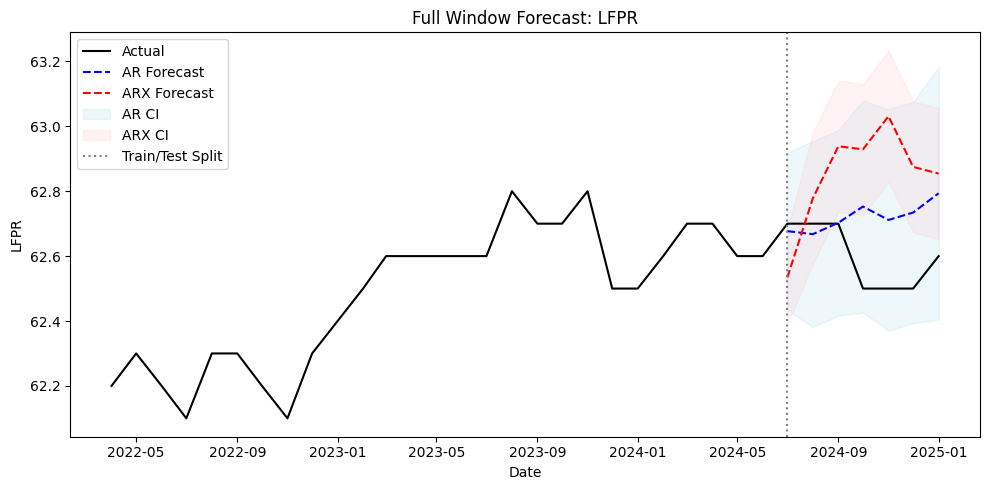

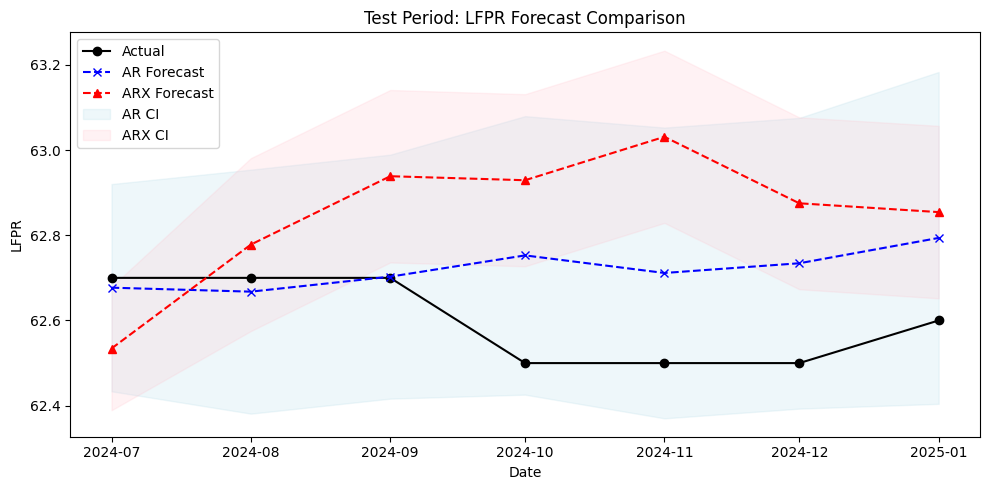

### Model Forecast Accuracy Metrics

,R2_train,MAE_test,RMSE_test,MAPE_test
AR,0.539835,0.135773,0.170123,0.217123
ARX,0.733470,0.295977,0.329910,0.473118


### Model Assumption Check

,Breusch-Pagan p,Shapiro p,Anderson stat,Anderson crit,Mean resid,Durbin-Watson
AR,nan,0.646798,0.235446,"[(15.0, 0.511), (10.0, 0.582), (5.0, 0.699), (2.5, 0.815), (1.0, 0.969)]",0.005076,1.765619
ARX,0.940000,0.502459,0.431874,"[(15.0, 0.511), (10.0, 0.582), (5.0, 0.699), (2.5, 0.815), (1.0, 0.969)]",0.009073,2.050082


{'metrics_ar': {'R2_train': 0.5398354846443587,
  'MAE_test': 0.13577290690054866,
  'RMSE_test': 0.17012306360462826,
  'MAPE_test': 0.21712348245861213},
 'metrics_arx': {'R2_train': 0.733470420985771,
  'MAE_test': 0.29597677333528843,
  'RMSE_test': 0.32991014278863545,
  'MAPE_test': 0.4731182654522147},
 'model_ar_order': (0, 0, 1),
 'model_ar_seasonal_order': (1, 1, 0, 3),
 'model_arx_order': (2, 0, 0),
 'model_arx_seasonal_order': (2, 1, 1, 3),
 'assumptions_ar': {'Breusch-Pagan p': nan,
  'Shapiro p': 0.6467984845248222,
  'Anderson stat': 0.23544638671380014,
  'Anderson crit': [(15.0, 0.511),
   (10.0, 0.582),
   (5.0, 0.699),
   (2.5, 0.815),
   (1.0, 0.969)],
  'Mean resid': 0.005075540760086708,
  'Durbin-Watson': 1.7656186188270622},
 'assumptions_arx': {'Breusch-Pagan p': 0.9400003058637556,
  'Shapiro p': 0.5024586549919206,
  'Anderson stat': 0.43187414757238685,
  'Anderson crit': [(15.0, 0.511),
   (10.0, 0.582),
   (5.0, 0.699),
   (2.5, 0.815),
   (1.0, 0.969)],
 

In [39]:
run_model('LFPR', ['Tether_lag0'], windows[1], show = True)

In [40]:
def run_univariate_sarimax_screening(df_macro, df_exog, macro, window, lag_prefix='Bitcoin', lag_range=7):
    """
    Screens exogenous variables one-by-one and returns their p-values from ARX model.
    """
    significance_results = []

    for i in range(lag_range):
        col = f"{lag_prefix}_lag{i}"
        if col not in df_exog.columns:
            print(f"[SKIPPED] {col} not in df_exog")
            continue

        try:
            result = run_model(macro, [col], window, show = False)
            pval = result['exog_pvals'].get(col, None)
        except Exception as e:
            print(f"[ERROR] {col}: {e}")
            pval = None

        significance_results.append((col, pval))

    return pd.DataFrame(significance_results, columns=['Variable', 'P-Value']).sort_values(by='P-Value')


In [41]:
asset_list= ['Bitcoin', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano','Tether', 'USD Coin']
run_univariate_sarimax_screening(df, df_exog,'CC', windows[0], lag_prefix='Litecoin', lag_range=7)

AR Order: (2, 0, 0) Seasonal: (0, 1, 0, 3)
ARX Order: (2, 0, 0) Seasonal: (2, 1, 0, 3)

=== AR Model Summary ===
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   25
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 3)   Log Likelihood                 -69.664
Date:                           Tue, 08 Jul 2025   AIC                            145.328
Time:                                   10:49:31   BIC                            148.601
Sample:                               07-01-2019   HQIC                           146.099
                                    - 07-01-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1    

,Variable,P-Value
6,Litecoin_lag6,0.000008
5,Litecoin_lag5,0.010081
4,Litecoin_lag4,0.023503
2,Litecoin_lag2,0.024557
1,Litecoin_lag1,0.051486
3,Litecoin_lag3,0.075725
0,Litecoin_lag0,0.349235


In [45]:
import pandas as pd

def calculate_mape(y_true, y_pred):
    return (abs((y_true - y_pred) / y_true)).mean() * 100

def run_baseline_ar(df_macro, macro, window):
    start_date, end_date = pd.to_datetime(window[0]), pd.to_datetime(window[1])
    series = df_macro[macro].loc[start_date:end_date].dropna().asfreq('MS')

    split_idx = int(len(series) * 0.8)
    if split_idx == 0 or split_idx >= len(series):
        raise ValueError("Not enough data to split")

    y_train = series.iloc[:split_idx]
    y_test = series.iloc[split_idx:]

    from statsmodels.tsa.statespace.sarimax import SARIMAX
    model = SARIMAX(y_train, order=(1, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)

    y_pred = model_fit.forecast(steps=len(y_test))
    return y_test, y_pred


def run_full_crypto_screening(df_macro, df_exog, macro, window, lag_range=7, pval_threshold=0.05):
    asset_list = ['Bitcoin', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano','Tether', 'USD Coin']
    final_results = []

    # === Get baseline MAPE ===
    try:
        y_test_base, y_pred_base = run_baseline_ar(df_macro, macro, window)
        baseline_mape = calculate_mape(y_test_base, y_pred_base)
    except Exception as e:
        print(f"[ERROR] Baseline AR model failed: {e}")
        return pd.DataFrame()

    for asset in asset_list:
        df_pvals = run_univariate_sarimax_screening(df_macro, df_exog, macro, window, lag_prefix=asset, lag_range=lag_range)
        df_pvals = df_pvals[df_pvals['P-Value'] < pval_threshold].copy()

        for _, row in df_pvals.iterrows():
            col = row['Variable']
            try:
                result = run_model(macro, [col], window, show=False)
                y_pred = result['y_pred']
                y_test = result['y_test']
                mape = calculate_mape(y_test, y_pred)
                improvement = baseline_mape - mape

                final_results.append({
                    'Variable': col,
                    'P-Value': row['P-Value'],
                    'MAPE % Improvement': improvement,
                    'New MAPE': mape,
                    'Baseline MAPE': baseline_mape
                })

            except Exception as e:
                print(f"[ERROR] MAPE calc for {col}: {e}")
                continue

    df_final = pd.DataFrame(final_results)
    if not df_final.empty:
        df_final = df_final.sort_values(by='MAPE % Improvement', ascending=False)

    return df_final


In [47]:
macro = 'CC'
df_results = run_full_crypto_screening(df, df_exog, macro, windows[0])
print(df_results)


AR Order: (2, 0, 0) Seasonal: (0, 1, 0, 3)
ARX Order: (2, 0, 0) Seasonal: (0, 1, 0, 3)

=== AR Model Summary ===
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   25
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 3)   Log Likelihood                 -69.664
Date:                           Tue, 08 Jul 2025   AIC                            145.328
Time:                                   10:54:03   BIC                            148.601
Sample:                               07-01-2019   HQIC                           146.099
                                    - 07-01-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1    